# Import and clean data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

In [2]:
path = '/kaggle/input/real-estate-estonia/data/2022-10-23/apartments/sale/harju/properties.csv'
data = pd.read_csv(path, index_col=0)
data.columns

Index(['Seisukord', 'Tube', 'Magamistube', 'Üldpind', 'Korrus',
       'Korruseid kokku', 'Omandiõigus', 'Turvasüsteem', 'Hind',
       'Energiamärgis', 'Materjal', 'Ehitusaasta', 'Küte', 'Sanitaar',
       'Vannitube', 'Lisaväärtused', 'Lisaruumid', 'Pliit', 'Side',
       'Rõdu pind', 'Tagatisraha', 'Suve kommunaalid', 'Talve kommunaalid',
       'Kinnistu number', 'Lift', 'Rõdu', 'Parkimine', 'Katus', 'Krunt',
       'Lisanduvad kommunaalkulud', 'Lisainfo', 'tasuta parkimine',
       'Ventilatsioon', 'Parkimiskohti', 'tasuline parkimine',
       'Lisanduvad kommunaalid', 'Maakleritasu', 'Piirangud'],
      dtype='object')

In [3]:
# Dropping uninformative columns with little to no values
DROP_COLS = ['Omandiõigus','Turvasüsteem','Krunt', 'Vannitube'
             ,'Pliit','Side','Tagatisraha','Kinnistu number'
             ,'Katus','Lisanduvad kommunaalkulud','Lisainfo','Parkimiskohti'
             ,'tasuline parkimine','Piirangud','Maakleritasu','Lisanduvad kommunaalid'
             ,'Lisaväärtused','Lisaruumid','Parkimine','tasuta parkimine','Ventilatsioon','Suve kommunaalid','Talve kommunaalid']
df = data.drop(DROP_COLS, axis=1)
df.columns

Index(['Seisukord', 'Tube', 'Magamistube', 'Üldpind', 'Korrus',
       'Korruseid kokku', 'Hind', 'Energiamärgis', 'Materjal', 'Ehitusaasta',
       'Küte', 'Sanitaar', 'Rõdu pind', 'Lift', 'Rõdu'],
      dtype='object')

In [4]:
COLUMN_MAPPING = {'Seisukord':'condition','Tube':'rooms','Magamistube':'bedrooms','Üldpind':'area','Korrus':'floor',
                 'Korruseid kokku':'total_floors','Hind':'price','Energiamärgis':'energy_label','Materjal':'house_material',
                 'Ehitusaasta':'year','Küte':'heating','Sanitaar':'sanitary','Lift':'lift','Rõdu':'balcony','Rõdu pind':'balcony_size'}
df.rename(columns=COLUMN_MAPPING, inplace=True)
df.columns

Index(['condition', 'rooms', 'bedrooms', 'area', 'floor', 'total_floors',
       'price', 'energy_label', 'house_material', 'year', 'heating',
       'sanitary', 'balcony_size', 'lift', 'balcony'],
      dtype='object')

In [5]:
# Dropping rows without the most important data
df = df[~df['price'].isna()]
df = df[~df['area'].isna()]
df = df[~df['floor'].isna()]
# Losing a lot of entries with removing nulls but simply using mean or dropping the column does not make sense
df = df[~df['year'].isnull()]
df = df[~df['rooms'].isnull()]


In [6]:
# If not provided, assume no balcony
df['balcony_size'] = df['balcony_size'].fillna(0)
df['balcony'] = df['balcony'].fillna(0)

def check_values(col1, col2):
    """Simple function to check if boths inputs are 0."""
    response = 1 if col1!=0 or col2!=0 else 0
    return(response)

# Apply the created function for each row to see if balcony exists.    
df['flag_balcony'] = df.apply(lambda x: check_values(x.balcony_size, x.balcony), axis=1)
df['flag_lift'] = (~df['lift'].isna()).astype(int)
df.drop(['lift','balcony_size','balcony'], axis=1, inplace=True)

<AxesSubplot:>

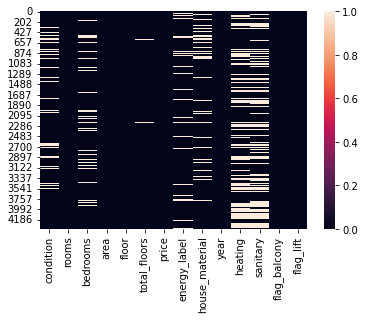

In [7]:
sns.heatmap(df.isnull())

In [8]:
df['energy_label'].unique()

array(['energiamärgis määramata', 'B', 'E', 'C', 'A', 'D', nan, 'F', 'H',
       'G', 'A,A'], dtype=object)

In [9]:
df['sanitary'].unique()[0:15]

array(['dušš', nan, 'vann,dušš,pesumasin',
       'pesumasin,wc ja vannituba eraldi,dušš,tsentraalne kanalisatsioon',
       'dušš,pesumasin', 'pesumasin,vann',
       'pesumasin,dušš,tsentraalne kanalisatsioon',
       'pesumasin,vann,wc ja vannituba eraldi', 'vann,saun,pesumasin',
       'wc ja vannituba eraldi', 'tsentraalne kanalisatsioon,dušš',
       'dušš,saun', 'dušš,pesumasin,saun', 'pesumasin,saun,dušš',
       'vann,wc ja vannituba eraldi,tsentraalne kanalisatsioon'],
      dtype=object)

In [10]:
df['heating'].unique()[0:15]

array(['keskküte', 'õhk-vesi soojuspump', 'gaasiküte',
       'põrandaküte,keskküte,gaasiküte', 'põrandaküte,keskküte', nan,
       'põrandaküte', 'keskküte,põrandaküte', 'õhksoojuspump,elektriküte',
       'põrandaküte,gaasiküte', 'kamin,gaasiküte',
       'gaasiküte,põrandaküte', 'õhksoojuspump,keskküte,põrandaküte',
       'õhksoojuspump,elektriküte,põrandaküte', 'keskküte,gaasiküte'],
      dtype=object)

In [11]:
# In order to preserve as much data as possible, filling NAs. Useful for feature engineering later.
df['house_material'] = df['house_material'].fillna('Unknown')
df['heating'] = df['heating'].fillna('Unknown')
df['condition'] = df['condition'].fillna('Unknown')
df['sanitary'] = df['sanitary'].fillna('Unknown')
df['energy_label'] = df['energy_label'].fillna('energiamärgis määramata')
df = df.replace("A,A","A")

In [12]:
#Create dummies for most important items
df['flag_shower'] = df['sanitary'].apply(lambda x: int('dušš' in x.strip().lower()))
df['flag_bath'] = df['sanitary'].apply(lambda x: int('vann' in x.strip().lower()))
df['flag_sauna'] = df['sanitary'].apply(lambda x: int('saun' in x.strip().lower()))
df['flag_generalheat'] = df['heating'].apply(lambda x: int('keskküte' in x.strip().lower()))
df['flag_floorheat'] = df['heating'].apply(lambda x: int('põrandaküte' in x.strip().lower()))
df['flag_gasheat'] = df['heating'].apply(lambda x: int('gaasiküte' in x.strip().lower()))
df['flag_electricalheat'] = df['heating'].apply(lambda x: int('õhksoojuspump' in x.strip().lower()))
df.drop('heating', axis=1, inplace=True)
df.drop('sanitary', axis=1, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3696 entries, 0 to 4370
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   condition            3696 non-null   object 
 1   rooms                3696 non-null   float64
 2   bedrooms             3164 non-null   float64
 3   area                 3696 non-null   float64
 4   floor                3696 non-null   float64
 5   total_floors         3667 non-null   float64
 6   price                3696 non-null   float64
 7   energy_label         3696 non-null   object 
 8   house_material       3696 non-null   object 
 9   year                 3696 non-null   float64
 10  flag_balcony         3696 non-null   int64  
 11  flag_lift            3696 non-null   int64  
 12  flag_shower          3696 non-null   int64  
 13  flag_bath            3696 non-null   int64  
 14  flag_sauna           3696 non-null   int64  
 15  flag_generalheat     3696 non-null   i

In [14]:
df[df['floor']==30.0]

,condition,rooms,bedrooms,area,floor,total_floors,price,energy_label,house_material,year,flag_balcony,flag_lift,flag_shower,flag_bath,flag_sauna,flag_generalheat,flag_floorheat,flag_gasheat,flag_electricalheat
2568,vajab kapitaalremonti,2.0,1.0,50.0,30.0,30.0,320000.0,energiamärgis määramata,paneelmaja,2006.0,0,1,1,0,0,1,0,0,0


In [15]:
df.describe()
df = df[df['bedrooms']!=6]
df = df[df['rooms']<9]
df = df[df['floor']<=30.0]

In [16]:
df.groupby('rooms').mean()

,bedrooms,area,floor,total_floors,price,year,flag_balcony,flag_lift,flag_shower,flag_bath,flag_sauna,flag_generalheat,flag_floorheat,flag_gasheat,flag_electricalheat
rooms,,,,,,,,,,,,,,,
1.0,1.000000,30.597792,2.925558,4.965000,111837.982630,1985.339950,0.310174,0.297767,0.605459,0.258065,0.007444,0.669975,0.250620,0.037221,0.007444
2.0,1.050847,48.227262,3.598266,5.971657,165281.560694,1994.708092,0.530347,0.341040,0.487717,0.278902,0.026734,0.522399,0.242775,0.078757,0.015896
3.0,2.017021,69.513367,3.606037,6.097733,236175.469814,1998.260062,0.668731,0.426471,0.444272,0.464396,0.075077,0.541022,0.307276,0.092879,0.022446
4.0,2.967347,95.530133,3.289524,5.271154,329389.095124,2001.836190,0.716190,0.438095,0.512381,0.520000,0.180952,0.485714,0.390476,0.104762,0.022857
5.0,3.734177,117.835366,3.439024,5.000000,429205.243902,2001.024390,0.658537,0.524390,0.646341,0.609756,0.317073,0.475610,0.426829,0.158537,0.012195
6.0,4.500000,174.100000,2.800000,5.800000,391800.000000,1914.000000,0.600000,0.400000,0.200000,0.200000,0.200000,0.200000,0.200000,0.000000,0.200000
7.0,4.500000,193.250000,2.500000,5.000000,589500.000000,1964.500000,0.500000,0.500000,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000


In [17]:
# Imputing with means based on most correlated features
df['total_floors'] = df['total_floors'].fillna(df.groupby('floor')['total_floors'].transform('mean').map(int))
df['bedrooms'] = df['bedrooms'].fillna(df.groupby('rooms')['bedrooms'].transform('mean').map(int))

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3693 entries, 0 to 4370
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   condition            3693 non-null   object 
 1   rooms                3693 non-null   float64
 2   bedrooms             3693 non-null   float64
 3   area                 3693 non-null   float64
 4   floor                3693 non-null   float64
 5   total_floors         3693 non-null   float64
 6   price                3693 non-null   float64
 7   energy_label         3693 non-null   object 
 8   house_material       3693 non-null   object 
 9   year                 3693 non-null   float64
 10  flag_balcony         3693 non-null   int64  
 11  flag_lift            3693 non-null   int64  
 12  flag_shower          3693 non-null   int64  
 13  flag_bath            3693 non-null   int64  
 14  flag_sauna           3693 non-null   int64  
 15  flag_generalheat     3693 non-null   i

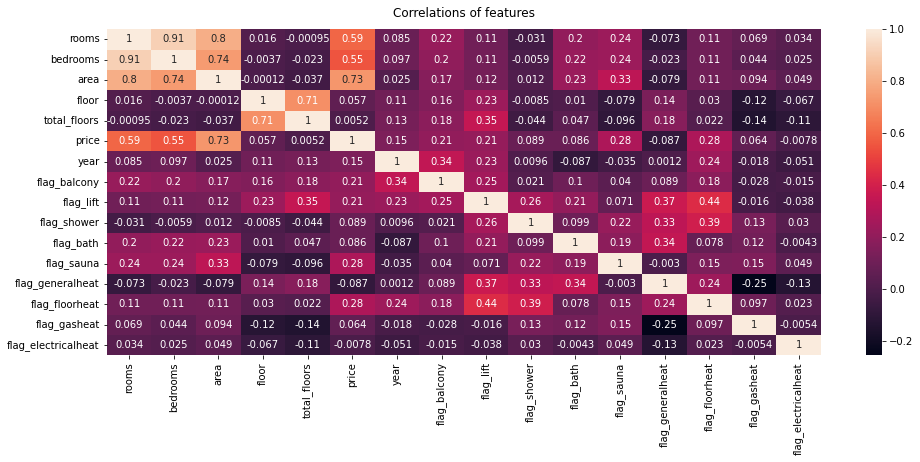

In [19]:
plt.figure(figsize=(16, 6))
correlations = sns.heatmap(df.corr(), annot=True)
correlations.set_title('Correlations of features', fontdict={'fontsize':12}, pad=12);

In [20]:
df['house_material'].unique()[0:25]

array(['kivimaja', 'betoonmaja', 'betoonmaja,kivimaja', 'paneelmaja',
       'Unknown', 'puitmaja', 'betoonmaja,kivimaja,plokkmaja',
       'plokkmaja,paneelmaja', 'kivimaja,paneelmaja', 'plokkmaja',
       'paneelmaja,kivimaja', 'betoonmaja,paneelmaja,kivimaja',
       'paneelmaja,kivimaja,plokkmaja', 'palk-kivimaja', 'palkmaja',
       'plokkmaja,kivimaja', 'betoonmaja,plokkmaja',
       'paneelmaja,kivimaja,betoonmaja', 'kivimaja,plokkmaja',
       'betoonmaja,paneelmaja', 'paneelmaja,betoonmaja',
       'puitmaja,palk-kivimaja', 'paneelmaja,plokkmaja,kivimaja',
       'kivimaja,betoonmaja,paneelmaja',
       'paneelmaja,betoonmaja,kivimaja,plokkmaja'], dtype=object)

In [21]:
df['flag_brick'] = df['house_material'].apply(lambda x: int('plokkmaja' in x.strip().lower()))
df['flag_panel'] = df['house_material'].apply(lambda x: int('paneelmaja' in x.strip().lower()))
df['flag_beton'] = df['house_material'].apply(lambda x: int('betoonmaja' in x.strip().lower()))
df['flag_stone'] = df['house_material'].apply(lambda x: int('kivimaja' in x.strip().lower()))
df['flag_wood'] = df['house_material'].apply(lambda x: int('puitmaja' in x.strip().lower()))
df.drop('house_material', axis=1, inplace=True)

In [22]:
df['condition'].unique()[0:25]

array(['vajab renoveerimist', 'uusehitis', 'valmis',
       'valmis,renoveeritud', 'renoveeritud', 'Unknown',
       'vajab kapitaalremonti', 'uusehitis,uus viimistlus',
       'valmimisjärgus', 'renoveeritud,valmis',
       'uus viimistlus,uusehitis,valmis',
       'vajab kapitaalremonti,vajab renoveerimist,valmis',
       'uus viimistlus,renoveeritud,valmis', 'uusehitis,valmis',
       'valmis,renoveeritud,uus viimistlus', 'uus viimistlus,valmis',
       'san remont tehtud', 'valmis,uusehitis', 'uus viimistlus',
       'uus viimistlus,valmis,renoveeritud',
       'uus viimistlus,renoveeritud,uusehitis,valmis',
       'uusehitis,valmis,renoveeritud,uus viimistlus',
       'san remont tehtud,renoveeritud,uus viimistlus,valmis',
       'valmis,vajab renoveerimist', 'uus viimistlus,renoveeritud'],
      dtype=object)

In [23]:
df['flag_newbuilding'] = df['condition'].apply(lambda x: int('uusehitis' in x.strip().lower()))
df['flag_indevelopment'] = df['condition'].apply(lambda x: int('valmimisjärgus' in x.strip().lower()))
df['flag_renovated'] = df['condition'].apply(lambda x: int('renoveeritud' in x.strip().lower()))
df['flag_needsrenovation'] = df['condition'].apply(lambda x: int('vajab renoveerimist' in x.strip().lower()))
df.drop('condition', axis=1, inplace=True)

In [24]:
summary = df.describe()
for col in summary:
    if col[0:4]=='flag':
        print("There are "+str(round(summary[col][1]*summary[col][0]))+" entries for "+col)

There are 2157 entries for flag_balcony
There are 1419 entries for flag_lift
There are 1817 entries for flag_shower
There are 1414 entries for flag_bath
There are 259 entries for flag_sauna
There are 1988 entries for flag_generalheat
There are 1075 entries for flag_floorheat
There are 312 entries for flag_gasheat
There are 68 entries for flag_electricalheat
There are 45 entries for flag_brick
There are 1177 entries for flag_panel
There are 116 entries for flag_beton
There are 1827 entries for flag_stone
There are 163 entries for flag_wood
There are 1737 entries for flag_newbuilding
There are 26 entries for flag_indevelopment
There are 578 entries for flag_renovated
There are 202 entries for flag_needsrenovation


In [25]:
px.box(df,x='rooms',y='price',color='rooms',template='plotly_dark',title='<b> Sales Price per different rooms')

In [26]:
px.box(df,x='floor',y='price',color='floor',template='plotly_dark',title='<b> Sales Price per different floor')

In [27]:
px.box(df,x='bedrooms',y='price',color='bedrooms',template='plotly_dark',title='<b> Sales Price per different bedrooms')

# Model

In [28]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.pipeline import make_pipeline
import numpy as np


In [29]:
target_column = 'price'


In [30]:
categorical_cols = [c for c in df.columns if df[c].dtype in [object]]
numerical_cols = [c for c in df.columns if df[c].dtype in [float, int] and c not in [target_column]]
print("Categorical columns are: "+ ", ".join(categorical_cols))
print("Numerical columns are: "+ ", ".join(numerical_cols))

Categorical columns are: energy_label
Numerical columns are: rooms, bedrooms, area, floor, total_floors, year, flag_balcony, flag_lift, flag_shower, flag_bath, flag_sauna, flag_generalheat, flag_floorheat, flag_gasheat, flag_electricalheat, flag_brick, flag_panel, flag_beton, flag_stone, flag_wood, flag_newbuilding, flag_indevelopment, flag_renovated, flag_needsrenovation


In [31]:
X = df[numerical_cols+categorical_cols]
y = df[target_column]

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
def cv(model, params):
    grid = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    return(grid.best_estimator_)

In [34]:
lgbm = LGBMRegressor()
params = {}
params['lgbmregressor__num_leaves'] = [7, 14, 21, 28, 31, 50]
params['lgbmregressor__max_depth'] = [-1, 3, 5, 8]
params['lgbmregressor__learning_rate'] = [0.15,0.1, 0.01, 0.001]
params['lgbmregressor__boosting_type'] = ['gbdt','dart','goss']


model = make_pipeline(ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),    
    ]),
    lgbm)

In [35]:
best_model = cv(model,params)
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
print("The RMSFE error is:", round(mean_squared_error(y_test,preds)**(1/2),2))
print("The R2 is:", round(r2_score(y_test, preds),2))

{'lgbmregressor__boosting_type': 'goss', 'lgbmregressor__learning_rate': 0.15, 'lgbmregressor__max_depth': -1, 'lgbmregressor__num_leaves': 28}
The RMSFE error is: 50361.53
The R2 is: 0.82


In [36]:
rf = RandomForestRegressor()
params = {}
params['randomforestregressor__max_depth'] = [1,5,15,30]
params['randomforestregressor__n_estimators'] = [10,50,100,150]
params['randomforestregressor__min_samples_split'] = [2,4,8]
params['randomforestregressor__max_features'] = ["auto", "sqrt", "log2"]
params['randomforestregressor__bootstrap'] = [True, False]

model = make_pipeline(ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),    
    ]),rf
    )

In [37]:
best_model = cv(model,params)
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
print("The RMSFE error is:", round(mean_squared_error(y_test,preds)**(1/2),2))
print("The R2 is:", round(r2_score(y_test, preds),2))

{'randomforestregressor__bootstrap': False, 'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50}
The RMSFE error is: 49332.18
The R2 is: 0.83


In [38]:
lm = LinearRegression()
model = make_pipeline(ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),    
    ]),lm
    )
model.fit(X_train,y_train)
preds = model.predict(X_test)
print("The RMSFE error is:", round(mean_squared_error(y_test,preds)**(1/2),2))
print("The R2 is:", round(r2_score(y_test, preds),2))

The RMSFE error is: 70154.55
The R2 is: 0.65
